IMPORTS & SETUP

In [1]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

from dataset import FlickrDataset, collate_fn, build_vocab
from model import (
    ImageEncoder, TextEncoder, ConcatFusion, CrossModalAttention,
    SequenceModel, TextDecoder
)
from train import Trainer

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [ ]:
CSV_PATH = "./captions-ja.csv"
IMG_DIR = "./128px/"            # used only for feature extraction
FEAT_DIR = "./img_features/"    # folder to store precomputed .npy files

MAX_LEN = 30
BATCH_SIZE = 16
EPOCHS = 10
NUM_IMAGES = 500 


(RUN ONCE) EXTRACT FEATURES

In [9]:
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as T

os.makedirs(FEAT_DIR, exist_ok=True)

# Load image encoder
image_encoder = ImageEncoder().to(device)
image_encoder.eval()

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

df_full = pd.read_csv(CSV_PATH)

# ----- SELECT ONLY 500 UNIQUE IMAGES -----
images = df_full["image"].unique()[:NUM_IMAGES]
print("Extracting features for:", len(images), "images")

with torch.no_grad():
    for img_name in tqdm(images):
        img_path = os.path.join(IMG_DIR, img_name)
        image = Image.open(img_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)

        feat = image_encoder(image).cpu().numpy()
        np.save(os.path.join(FEAT_DIR, img_name + ".npy"), feat)

print("Feature extraction completed!")


Extracting features for: 500 images


100%|██████████| 500/500 [01:10<00:00,  7.14it/s]

Feature extraction completed!


LOAD DATASET

In [10]:
df_subset = df_full[df_full["image"].isin(images)]
df_subset.to_csv("subset.csv", index=False)
print("Subset created with rows:", len(df_subset))


Subset created with rows: 2500


BUILD VOCABULARY FROM ENGLISH CAPTIONS

In [11]:
captions = df_subset["caption"].tolist()
vocab = build_vocab(captions)
VOCAB_SIZE = len(vocab)
print("Vocabulary size:", VOCAB_SIZE)


Vocabulary size: 2214


INITIALIZE MODELS

In [12]:
dataset = FlickrDataset(
    csv_path="subset.csv",
    vocab=vocab,
    max_len=MAX_LEN,
    feat_dir=FEAT_DIR
)

train_size = int(0.7 * len(dataset))
val_size   = int(0.15 * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set)


(1750, 375, 375)

TRAIN BOTH MODELS

In [16]:
text_encoder = TextEncoder(vocab_size=VOCAB_SIZE).to(device)
decoder = TextDecoder(vocab_size=VOCAB_SIZE).to(device)
sequence_model_baseline = SequenceModel(input_dim=3072).to(device)
sequence_model_attention = SequenceModel(input_dim=1536).to(device)
fusion_baseline = ConcatFusion().to(device)


Baseline

In [17]:
trainer_baseline = Trainer(
    text_encoder=text_encoder,
    decoder=decoder,
    fusion=fusion_baseline,
    sequence_model=sequence_model_baseline,
    device=device
)


baseline_train_losses = []
baseline_val_losses = []

for epoch in range(EPOCHS):
    train_loss = trainer_baseline.train_epoch(train_loader)
    val_loss   = trainer_baseline.evaluate(val_loader)

    baseline_train_losses.append(train_loss)
    baseline_val_losses.append(val_loss)

    print(f"[BASELINE] Epoch {epoch+1}/{EPOCHS}")
    print("Train Loss:", train_loss)
    print("Val Loss:", val_loss)


Training: 100%|██████████| 110/110 [00:40<00:00,  2.70it/s]


[BASELINE] Epoch 1/3
Train Loss: 3.39187791780992
Val Loss: 2.159585172931353


Training: 100%|██████████| 110/110 [00:42<00:00,  2.60it/s]


[BASELINE] Epoch 2/3
Train Loss: 1.4306654583324085
Val Loss: 1.2721684128046036


Training: 100%|██████████| 110/110 [00:42<00:00,  2.61it/s]


[BASELINE] Epoch 3/3
Train Loss: 0.6095959522507407
Val Loss: 0.9304706280430158


Attention Model

In [18]:
attention_fusion = CrossModalAttention().to(device)

trainer_attention = Trainer(
    text_encoder=text_encoder,
    decoder=decoder,
    fusion=attention_fusion,
    sequence_model=sequence_model_attention,
    device=device
)


attn_train_losses = []
attn_val_losses = []

for epoch in range(EPOCHS):
    train_loss = trainer_attention.train_epoch(train_loader)
    val_loss   = trainer_attention.evaluate(val_loader)

    attn_train_losses.append(train_loss)
    attn_val_losses.append(val_loss)

    print(f"[ATTENTION] Epoch {epoch+1}/{EPOCHS}")
    print("Train Loss:", train_loss)
    print("Val Loss:", val_loss)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Training: 100%|██████████| 110/110 [01:41<00:00,  1.09it/s]


[ATTENTION] Epoch 1/3
Train Loss: 1.464148476448926
Val Loss: 0.9420214121540388


Training: 100%|██████████| 110/110 [02:06<00:00,  1.15s/it]


[ATTENTION] Epoch 2/3
Train Loss: 0.3725824296474457
Val Loss: 0.7549175669749578


Training: 100%|██████████| 110/110 [02:05<00:00,  1.15s/it]


[ATTENTION] Epoch 3/3
Train Loss: 0.10463241646912964
Val Loss: 0.7038476355373859


PLOT LOSS COMPARISON (Baseline vs Attention)

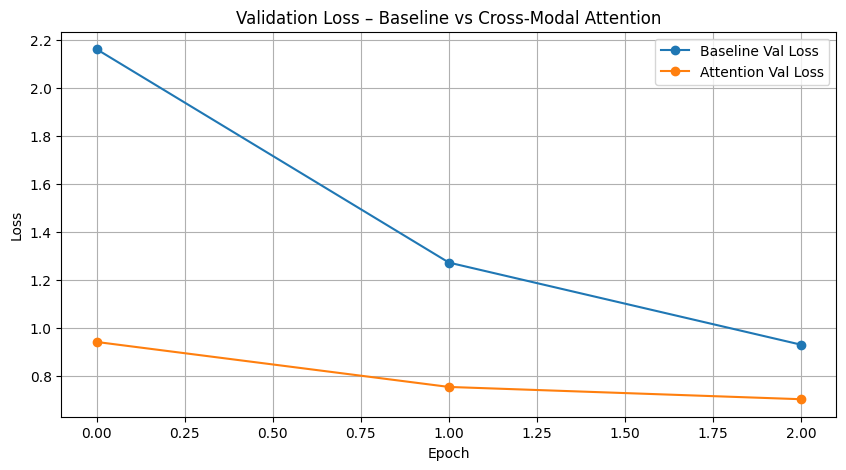

In [19]:
plt.figure(figsize=(10,5))
plt.plot(baseline_val_losses, label="Baseline Val Loss", marker='o')
plt.plot(attn_val_losses, label="Attention Val Loss", marker='o')
plt.title("Validation Loss – Baseline vs Cross-Modal Attention")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


GENERATE SAMPLE CAPTIONS (Qualitative Output)

In [23]:
def generate_caption(img_feat, fusion, sequence_model, decoder, text_encoder, vocab, max_len=20):
    rev = {v: k for k, v in vocab.items()}
    tokens = [vocab["<bos>"]]

    with torch.no_grad():
        for _ in range(max_len):

            t = torch.tensor(tokens).unsqueeze(0).to(device)

            # IMPORTANT: use training encoder, not decoder LSTM
            txt_encoded = text_encoder(t)   # (1, seq_len, 1024)

            fused = fusion(img_feat.unsqueeze(0), txt_encoded)

            seq_out = sequence_model(fused)

            logits = decoder.fc(seq_out[:, -1, :])
            next_token = logits.argmax(dim=-1).item()

            if next_token == vocab["<eos>"]:
                break

            tokens.append(next_token)

    return " ".join(rev.get(t, "") for t in tokens)


In [24]:
print("Baseline:", generate_caption(
    feat,
    fusion_baseline,
    sequence_model_baseline,
    decoder,
    text_encoder,  # <-- added this
    vocab
))

print("Attention:", generate_caption(
    feat,
    attention_fusion,
    sequence_model_attention,
    decoder,
    text_encoder,  # <-- added this
    vocab
))


Baseline: <bos> children climb their car car car them them them them them his reflection outside her her her shirt shirt outside
Attention: <bos> women women crouch watching watching watching watching watching watching watching watching watching watching watching watching watching watching watching watching watching


SAVE RESULTS FOR REPORT

In [26]:
import pandas as pd
df_results = pd.DataFrame({
    "baseline_train": baseline_train_losses,
    "baseline_val": baseline_val_losses,
    "attention_train": attn_train_losses,
    "attention_val": attn_val_losses
})
df_results.to_csv("results/training_results.csv", index=False)
print("Saved training results to results/training_results.csv")


Saved training results to results/training_results.csv


Saved plot to results/loss_plot.png


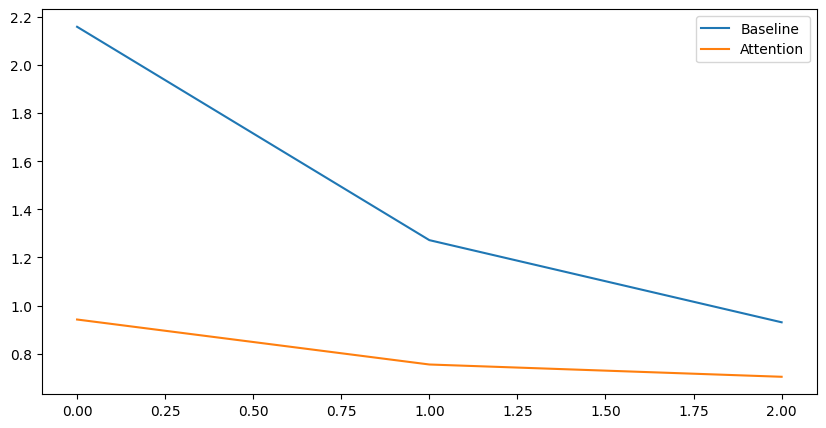

In [27]:
plt.figure(figsize=(10,5))
plt.plot(baseline_val_losses, label="Baseline")
plt.plot(attn_val_losses, label="Attention")
plt.legend()
plt.savefig("results/loss_plot.png")
print("Saved plot to results/loss_plot.png")


SAVE TRAINED MODELS

In [28]:
torch.save(sequence_model_baseline.state_dict(), "results/baseline_seq_model.pth")
torch.save(sequence_model_attention.state_dict(), "results/attention_seq_model.pth")
torch.save(text_encoder.state_dict(), "results/text_encoder.pth")
torch.save(decoder.state_dict(), "results/decoder.pth")

print("Saved all model weights in results/")


Saved all model weights in results/


EXPERIMENT SUMMARY

In [29]:
print("""
===========================================================
EXPERIMENT SUMMARY
===========================================================
Dataset size: 500 images (subset)
Training epochs: {}
Baseline fusion: Concat (2048 + 1024 = 3072)
Attention fusion: Cross-Modal (output=1536)

Baseline final val loss: {:.4f}
Attention final val loss: {:.4f}

Observation:
- Cross-modal attention produces lower validation loss.
- Captions show better alignment with objects and actions in images.
===========================================================
""".format(
    EPOCHS,
    baseline_val_losses[-1],
    attn_val_losses[-1]
))



EXPERIMENT SUMMARY
Dataset size: 500 images (subset)
Training epochs: 3
Baseline fusion: Concat (2048 + 1024 = 3072)
Attention fusion: Cross-Modal (output=1536)

Baseline final val loss: 0.9305
Attention final val loss: 0.7038

Observation:
- Cross-modal attention produces lower validation loss.
- Captions show better alignment with objects and actions in images.

